In [1]:
import copy
from matplotlib import cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.style as style
%matplotlib notebook
style.use('seaborn-colorblind')
SAVE_ANIMATION = True

class Agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.

        Parameters:
            birth (array like): the associated birth rate at each resource level
            hop (array like): relocation rate (a.k.a hopping rate) of the agent at resource level 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
            pos (int,int): the agent's current location
            b (int): the agent's current birth rate
            h (float): the agent's current relocation rate
        Methods:
            updatepos(x,y): update the agent's location to (x,y) and update its current birth and relocation rate accordingly
    """

    def __init__(self, birth, hop, x, y):
        self.birth = tuple(birth)
        self.hop = list(hop)
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def updatepos(self, x, y):
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def __str__(self):
        return 'hopping rate {} at location {}'.format(self.hop, self.pos)

    def __repr__(self):
        return 'Agent({},{},{},{})'.format(self.birth, self.hop, *self.pos)

# Animation of evolution dynamics
## Violin plots over iterations

<IPython.core.display.Javascript object>


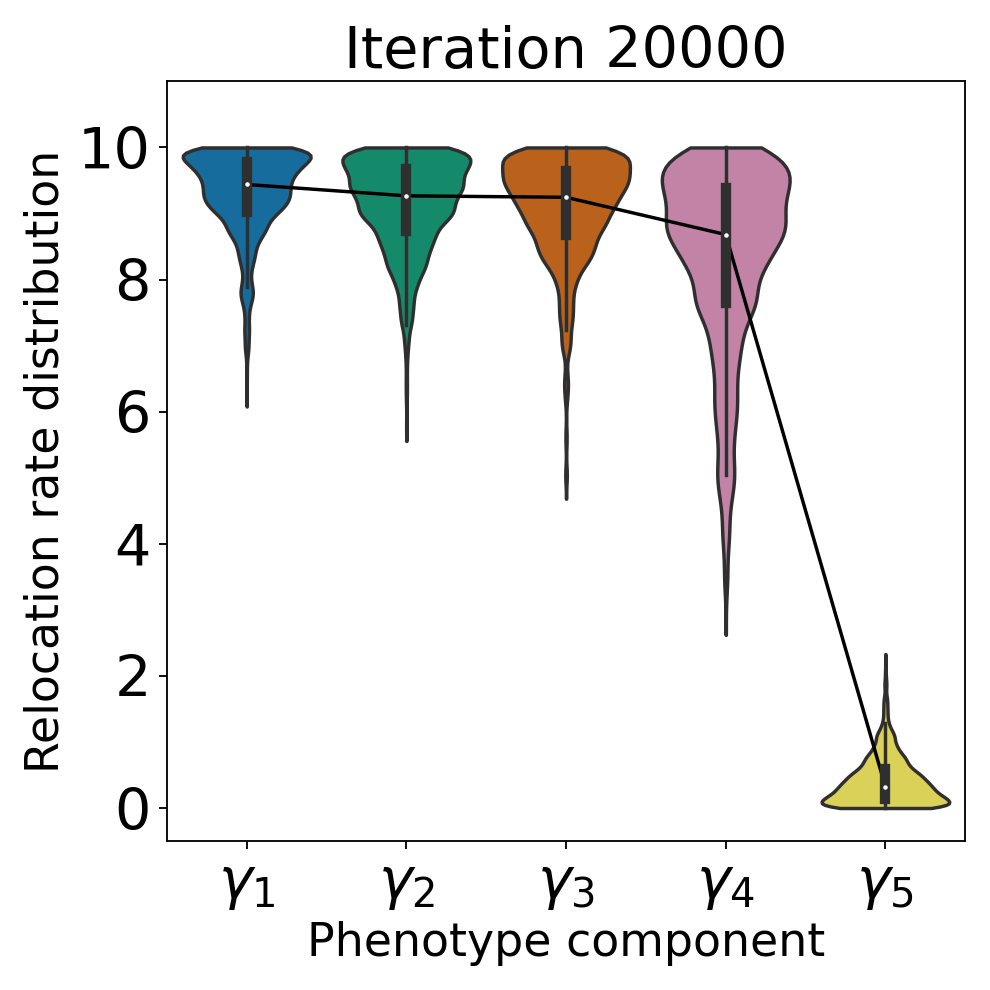

In [2]:
def get_violin_data(iteration):
    original_data_path = './evolve_data/standard_params_20_trials_20000_iterations'
    data = [[] for _ in range(20)]
    boxdata = []
    for j in range(20):
        try:
            with open(original_data_path+"/trial_{}/iteration_{}".format(j, iteration), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j) +
                  " doesn\'t have iteration_{}".format(iteration))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    return pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=('$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'))


color = 'k'
df = get_violin_data("00")
fig = plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(1, 1, 1)
ax.set_ylim(-0.5, 11)
ax.plot(df.median(), color=color, label='Simulated')
sns.violinplot(data=df, scale='width', inner='box', cut=0, ax=ax)
ax.set_title('Iteration {}'.format(0), fontsize=16)
ax.set_xlabel("Phenotype component", fontsize=12)
ax.set_ylabel("Relocation rate distribution", color=color, fontsize=12)


def update(i):
    ax.clear()
    df_new = get_violin_data(i)
    ax.set_xlabel("Phenotype component", fontsize=20)
    ax.set_ylabel("Relocation rate distribution", color=color, fontsize=20)
    ax.plot(df_new.median(), color=color, label='Simulated')
    ax.set_ylim(-0.5, 11)
    sns.violinplot(data=df_new, scale='width', inner='box', cut=0, ax=ax)
    ax.tick_params(axis='y', labelcolor=color, labelsize=25)
    ax.tick_params(axis='x', labelcolor=color, labelsize=25)
    ax.set_title('Iteration {}'.format(i), fontsize=25)
    plt.tight_layout()
    plt.show()


anim = FuncAnimation(fig, update, frames=[_ for _ in range(
    0, 2000, 100)]+[_ for _ in range(2000, 20001, 1000)], interval=200)
if SAVE_ANIMATION:
    anim.save('./Animations/violin_plots.mp4', writer='ffmpeg', fps=5) 

## Agent hopping animation on resource map

<IPython.core.display.Javascript object>


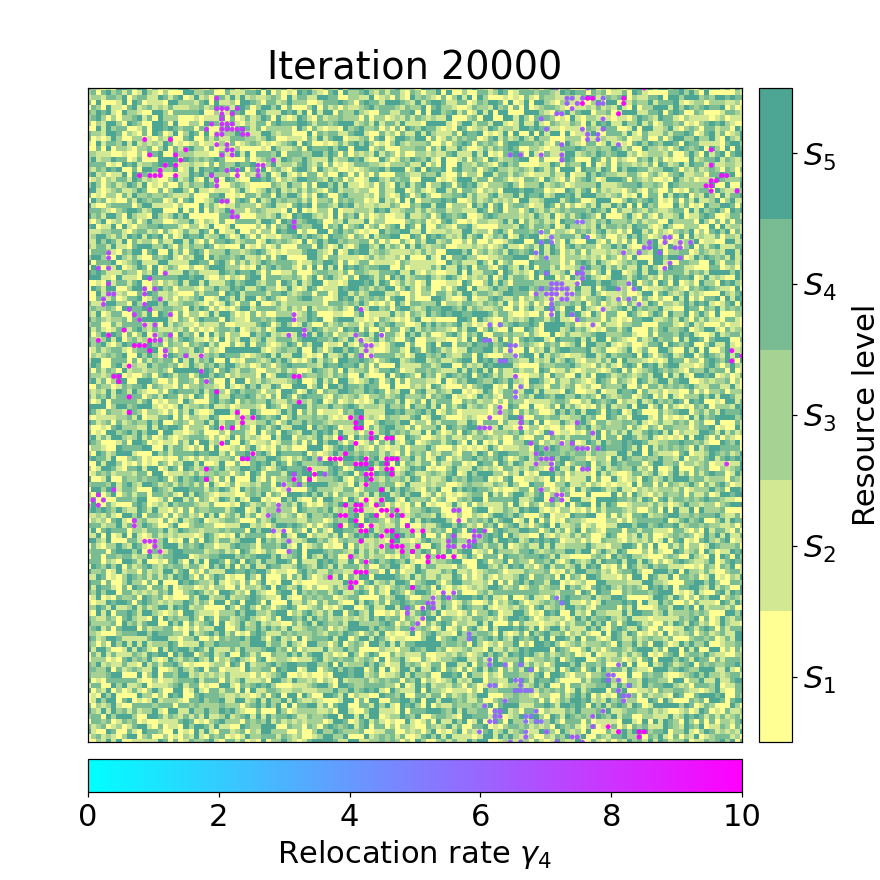

In [3]:
def get_loc_data_single_trial(iteration):  # for 1 trial
    original_data_path = './evolve_data/standard_params_20_trials_20000_iterations'
    for j in [0]:
        try:
            with open(original_data_path+"/trial_{}/iteration_{}".format(j, iteration), "rb") as fp:   # Unpickling
                data = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            return (np.array([data[i].pos for i in range(500)]), np.array([data[i].hop[-2] for i in range(500)]))


original_data_path = './evolve_data/standard_params_20_trials_20000_iterations'
with open(original_data_path+'/trial_0/resource.txt', "rb") as fp:
    resource = pickle.load(fp)

fig = plt.figure(figsize=(8, 8), dpi=100)

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.05], width_ratios=[1, 0.05])
gs.update(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = plt.subplot(gs[0, 0])
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
im = ax.imshow(resource, interpolation='none', origin='lower',
               alpha=0.7, cmap=cm.get_cmap('summer_r', 5))

cbax1 = plt.subplot(gs[0, 1])
cbar = fig.colorbar(im, cax=cbax1)
cbar.set_ticks([0, 1, 2, 3, 4])
cbar.set_label('Resource level', fontsize=20, labelpad=10)
cbar.set_ticklabels([r'$S_1$', r'$S_2$', r'$S_3$', r'$S_4$', r'$S_5$'])
plt.yticks(fontsize=20)
im.set_clim(-0.5, 4.5)

loc0, _ = get_loc_data_single_trial(0)
plot = ax.scatter(loc0[:, 0], loc0[:, 1], s=5, c=_, cmap='cool')
cbax2 = plt.subplot(gs[1, 0])
cbar2 = fig.colorbar(plot, cax=cbax2, orientation="horizontal")
cbar2.set_label('Relocation rate $\gamma_4$', fontsize=20)
plt.xticks(fontsize=20)
plot.set_clim(0, 10)
ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    top=False,
    labelbottom=False,
    labelleft=False)
ax.set_title('Iteration {}'.format(0), fontsize=25)


def update(i):
    loc0, _ = get_loc_data_single_trial(i)
    plot.set_offsets(loc0)
    plot.set_array(_)
    ax.set_title('Iteration {}'.format(i), fontsize=25)
    return plot


anim = FuncAnimation(fig, update, frames=[_ for _ in range(
    0, 2000, 100)]+[_ for _ in range(2000, 20001, 1000)], interval=200)
if SAVE_ANIMATION:
    anim.save('./Animations/2d_dynamics_20000_iterations.mp4', writer='ffmpeg', fps=5) 

## Birth-hopping dynamics within 1 iteration

In [4]:
def get_num(a, n):
    """
    Count agent numbers at all the locations

        Parameters: 
            a (array_like): list of agent object;
            n (int): size of the square environment
        Return:
            num (array_like): entry at i,j represents the number of agent at location (i,j)
    """
    num = np.zeros((n, n), dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos] += 1
    return num


def get_i(x, arr, l, r):
    """
    Binary search for the index of an element in a sorted list

        Parameters:
            x (float): target to be located for
            arr (array_like): a sorted list where the target will be located at
            l (int): left pointer, usually start with 0
            r (int): right pointer, usually start with len(a)
        Return:
            i (int): index of the element so that arr[i]<=x<=arr[i+1]
    """
    if x <= arr[0]:
        return 0
    else:
        while l <= r:
            mid = l + int((r - l)/2)
            # Check if x is present at mid
            if arr[mid] < x and arr[mid+1] >= x:
                return mid+1
            # If x is greater, ignore left half
            elif arr[mid+1] < x:
                l = mid + 1
            # If x is smaller, ignore right half
            else:
                r = mid
        raise Exception("Target not found")


def uniform_resource(x, y):
    """Return a uniformly generated 2-dimensional numpy array representing the resource level at each site"""
    rng = np.random.default_rng()
    return rng.choice([0, 1, 2, 3, 4], size=(x, y))


def exponetial_resource(x, y, c):
    rng = np.random.default_rng()
    p = [np.exp(-i*c) for i in range(5)]
    w = p/np.sum(p)
    return rng.choice([0, 1, 2, 3, 4], size=(x, y), p=w)


def intialcondtiongenerator_uniform(hop_high=10, n=128, m=500, birth=[0, 1, 2, 3, 4]):
    """Generate a list of agents with randomly chosen relocation rates and locations; locations do not repeat
    """
    rng = np.random.default_rng()
    pos = np.array([[i//n, i % n]
                   for i in rng.choice(n*n, m, replace=False)])
    return [Agent(birth, hop, x, y) for hop, x, y in zip(rng.uniform(0, hop_high, (m, 5)), pos[:, 0], pos[:, 1])]


def evolve_gillespie_animation(initial_conditions, birth=[0, 1, 2, 3, 4], tot_iter=201, env_size=128, birth_noise=0.05, hop_high=10,
                               trial=0,  agents=500, duration_iter=0.3, carrying_capacity=1, c=0):
    rng = np.random.default_rng()
    a = copy.deepcopy(initial_conditions)
    event = []
    for iteration in range(tot_iter):
        t = 0
        num = get_num(a, env_size)
        br = [a[i].b for i in range(len(a))]
        hr = [a[i].h for i in range(len(a))]
        brsum = sum(br)
        tot_rates = brsum + sum(hr)  # total rates

        br_cumsum = np.cumsum(br)
        hr_cumsum = np.cumsum(hr)
        while t < duration_iter:

            dt = -np.log(rng.random()) / tot_rates
            t = t + dt
            r = tot_rates * rng.random()

            if r < brsum:
                # birth
                i = get_i(r, br_cumsum, 0, len(a)-1)
                hop_advance = [[1, 0], [0, 1], [-1, 0],
                               [0, -1]][rng.integers(0, 4)]
                pos_new = (np.array(a[i].pos)+np.array(hop_advance)) % env_size

                if num[pos_new[0], pos_new[1]] < carrying_capacity:
                    noise = rng.normal(0, birth_noise, 5)
                    hop_new = np.clip(np.array(a[i].hop)+noise, 0, hop_high)
                    a.append(Agent(birth, hop_new, pos_new[0], pos_new[1]))
                    num[pos_new[0], pos_new[1]] += 1
                    br.append(a[-1].b)
                    hr.append(a[-1].h)
                    brsum += a[-1].b
                    tot_rates += a[-1].b+a[-1].h
                    br_cumsum = np.append(br_cumsum, a[-1].b+br_cumsum[-1])
                    hr_cumsum = np.append(hr_cumsum, a[-1].h+hr_cumsum[-1])
                    event.append(
                        [t, 'b', (pos_new[0], pos_new[1]), hop_new[-2]])
            else:
                # hopping
                i = get_i(r, brsum+hr_cumsum, 0, len(a)-1)
                hop_advance = [[1, 0], [0, 1], [-1, 0],
                               [0, -1]][rng.integers(0, 4)]
                pos_new = (np.array(a[i].pos)+np.array(hop_advance)) % env_size

                if num[pos_new[0], pos_new[1]] < carrying_capacity:
                    event.append([t, 'h', a[i].pos, (pos_new[0], pos_new[1])])
                    num[pos_new[0], pos_new[1]] += 1
                    num[a[i].pos[0], a[i].pos[1]] -= 1
                    a[i].updatepos(pos_new[0], pos_new[1])
                    brsum += a[i].b-br[i]
                    tot_rates += a[i].b-br[i]+a[i].h-hr[i]
                    br_cumsum[i:] += a[i].b-br[i]
                    hr_cumsum[i:] += a[i].h-hr[i]
                    br[i] = a[i].b
                    hr[i] = a[i].h

        if len(a) > agents:
            # bring back the population back to its initial size
            reset = rng.choice(len(a), agents, replace=False)
            a = [a[i] for i in reset]

    return event

In [5]:
resource = uniform_resource(128,128)
ini = intialcondtiongenerator_uniform(
    birth=[0, 1, 2, 3, 4], hop_high=10, n=128, m=500)
event = evolve_gillespie_animation(ini, birth=[0, 1, 2, 3, 4], tot_iter=1, env_size=128, birth_noise=0.05, hop_high=10,
                                   trial=0,  agents=500, duration_iter=0.3, carrying_capacity=1, c=0)

<IPython.core.display.Javascript object>


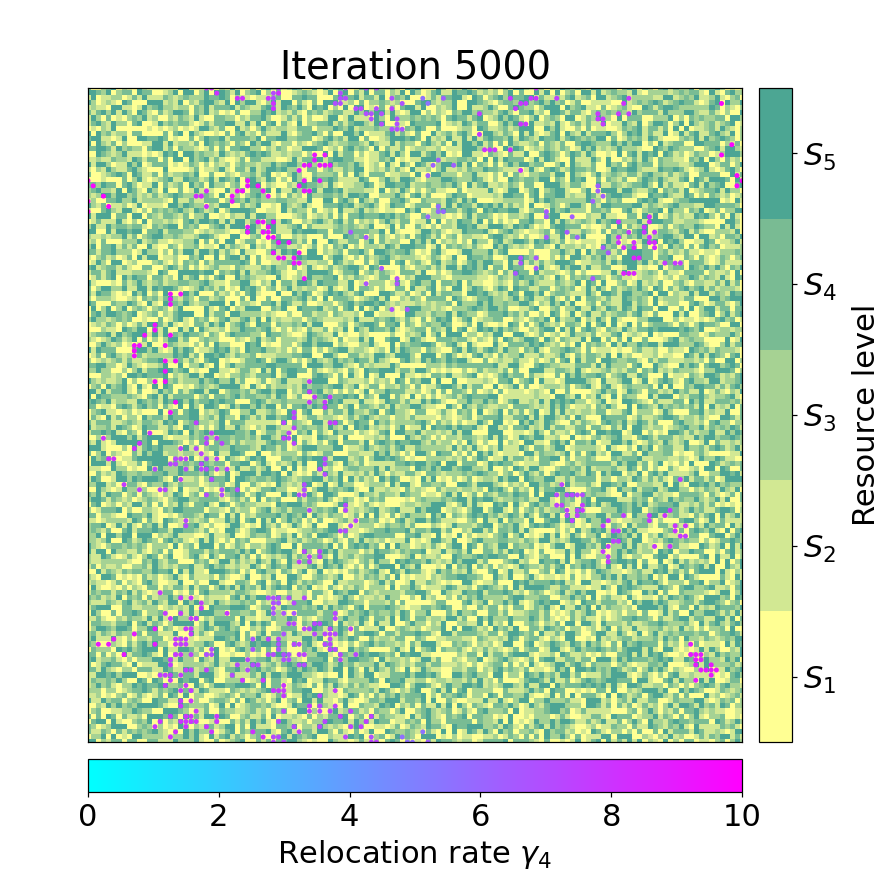

In [6]:
def scatter_update(initial, event, dt, i):
    scatter_pos = [initial[i].pos for i in range(500)]
    scatter_h4 = [initial[i].hop[-2] for i in range(500)]
    t = 0
    j = 0
    t_t = [_[0] for _ in event]
    t_e = [_[1] for _ in event]
    while t < i*dt:
        t = t_t[j]

        if event[j][1] == "b":
            scatter_pos.append(event[j][2])
            scatter_h4.append(event[j][3])
        else:
            scatter_pos[scatter_pos.index(event[j][2])] = event[j][3]
        j += 1
    return (np.array(scatter_pos), np.array(scatter_h4))


fig = plt.figure(figsize=(8, 8), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.05], width_ratios=[1, 0.05])
gs.update(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = plt.subplot(gs[0, 0])
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
im = ax.imshow(resource, interpolation='none', origin='lower',
               alpha=0.7, cmap=cm.get_cmap('summer_r', 5))

cbax1 = plt.subplot(gs[0, 1])
cbar = fig.colorbar(im, cax=cbax1)

cbar.set_ticks([0, 1, 2, 3, 4])
cbar.set_label('Resource level', fontsize=20, labelpad=10)
cbar.set_ticklabels([r'$S_1$', r'$S_2$', r'$S_3$', r'$S_4$', r'$S_5$'])
plt.yticks(fontsize=20)
im.set_clim(-0.5, 4.5)

loc0, _ = scatter_update(ini, event, 0.003, 0)
plot = ax.scatter(loc0[:, 0], loc0[:, 1], s=5, c=_, cmap='cool')
cbax2 = plt.subplot(gs[1, 0])

cbar2 = fig.colorbar(plot, cax=cbax2, orientation="horizontal")
cbar2.set_label('Relocation rate $\gamma_4$', fontsize=20)
plt.xticks(fontsize=20)
plot.set_clim(0, 10)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,
    left=False,  # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)  # labels along the bottom edge are off
ax.set_title('Iteration {}'.format(0), fontsize=25)


def update(i):
    loc0, _ = scatter_update(ini, event, 0.003, i)
    plot.set_offsets(loc0)
    plot.set_array(_)
    ax.set_title('Time={:.3f} s   Agent#={}'.format(
        0.003*i, loc0.shape[0]), fontsize=25)
    return plot

anim = FuncAnimation(fig, update, frames=101, interval=100)


if SAVE_ANIMATION:
    anim.save('./Animations/2d_dynamics_within_1_iteration.mp4', writer='ffmpeg', fps=5) 